In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [2]:
df = pd.read_csv('data/AmesHousing.csv')

In [3]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
df.shape

(2930, 82)

In [5]:
df['Total_Bathrooms'] = (df['Full Bath'] + 0.5 * df['Half Bath'] + df['Bsmt Full Bath'] + 0.5 * df['Bsmt Half Bath'])

df['House_Age'] = 2025 - df['Year Built']

df['Total_Square_Footage'] = (df['1st Flr SF'] + df['2nd Flr SF'] + df['Total Bsmt SF'])
    
df['Above_Ground_SF'] = df['1st Flr SF'] + df['2nd Flr SF']
    
df['Basement_Percentage'] = np.where(df['Total_Square_Footage'] > 0,df['Total Bsmt SF'] / df['Total_Square_Footage'],0)

df['Quality_Condition_Score'] = df['Overall Qual'] * df['Overall Cond']

df['Has_Garage'] = (df['Garage Type'] != 'No Garage').astype(int)

df['Total_Porch_SF'] = (df['Wood Deck SF'] + df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch'])
    
df['Has_Pool'] = (df['Pool QC'] != 'No Pool').astype(int)
    
df['Has_Fireplace'] = (df['Fireplace Qu'] != 'No Fireplace').astype(int)

df['Total_Rooms_Above_Grade'] = (df['Bedroom AbvGr'] + df['Kitchen AbvGr'] + df['TotRms AbvGrd'])

df['Premium_Features_Count'] = ((df['Mas Vnr Type'] != 'None').astype(int) + (df['Has_Fireplace']) + (df['Has_Pool']) + (df['Fence'] != 'No Fence').astype(int))

In [6]:
columns_to_drop = [
        'Full Bath', 'Half Bath', 'Bsmt Full Bath', 'Bsmt Half Bath',

        'Year Built', 'Year Remod/Add',

        '1st Flr SF', '2nd Flr SF', 'Total Bsmt SF',

        'BsmtFin SF 1', 'BsmtFin SF 2',

        'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',

        'Bedroom AbvGr', 'Kitchen AbvGr',

        'Garage Yr Blt'
    ]

existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=existing_cols_to_drop, inplace=True)

In [7]:
df=df.drop(columns=['Street','Utilities','Pool Area','Low Qual Fin SF'])

In [8]:
df['Mas Vnr Type'].fillna('None', inplace=True)

df['Garage Type'].fillna('No Garage', inplace=True)
df['Garage Qual'].fillna('No Garage', inplace=True)
df['Garage Cond'].fillna('No Garage', inplace=True)
df['Garage Finish'].fillna('No Garage', inplace=True)

df['Bsmt Qual'].fillna('No Basement', inplace=True)
df['Bsmt Cond'].fillna('No Basement', inplace=True)
df['Bsmt Exposure'].fillna('No', inplace=True)
df['BsmtFin Type 1'].fillna('No Basement', inplace=True)
df['BsmtFin Type 2'].fillna('No Basement', inplace=True)

df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)

df['Lot Frontage'].fillna(df['Lot Frontage'].median(), inplace=True)
df['Mas Vnr Area'].fillna(0, inplace=True)

df['Garage Area'].fillna(df['Garage Area'].median(), inplace=True)
df['Garage Cars'].fillna(df['Garage Cars'].median(), inplace=True)

df['Bsmt Unf SF'].fillna(df['Bsmt Unf SF'].median(), inplace=True)

C:\Users\swaya\AppData\Local\Temp\ipykernel_25968\3290573215.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Mas Vnr Type'].fillna('None', inplace=True)
C:\Users\swaya\AppData\Local\Temp\ipykernel_25968\3290573215.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [9]:
df.isna().sum()

Order                      0
PID                        0
MS SubClass                0
MS Zoning                  0
Lot Frontage               0
                          ..
Total_Porch_SF             0
Has_Pool                   0
Has_Fireplace              0
Total_Rooms_Above_Grade    0
Premium_Features_Count     0
Length: 71, dtype: int64

In [10]:
df.drop(columns=['Order','PID'])

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Alley,Lot Shape,Land Contour,Lot Config,Land Slope,Neighborhood,...,Total_Square_Footage,Above_Ground_SF,Basement_Percentage,Quality_Condition_Score,Has_Garage,Total_Porch_SF,Has_Pool,Has_Fireplace,Total_Rooms_Above_Grade,Premium_Features_Count
0,20,RL,141.0,31770,NaN,IR1,Lvl,Corner,Gtl,NAmes,...,2736.0,1656,0.394737,30,1,272,1,1,11,4
1,20,RH,80.0,11622,NaN,Reg,Lvl,Inside,Gtl,NAmes,...,1778.0,896,0.496063,30,1,260,1,1,8,4
2,20,RL,81.0,14267,NaN,IR1,Lvl,Corner,Gtl,NAmes,...,2658.0,1329,0.500000,36,1,429,1,1,10,4
3,20,RL,93.0,11160,NaN,Reg,Lvl,Corner,Gtl,NAmes,...,4220.0,2110,0.500000,35,1,0,1,1,12,4
4,60,RL,74.0,13830,NaN,IR1,Lvl,Inside,Gtl,Gilbert,...,2557.0,1629,0.362925,25,1,246,1,1,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,37.0,7937,NaN,IR1,Lvl,CulDSac,Gtl,Mitchel,...,2006.0,1003,0.500000,36,1,120,1,1,10,4
2926,20,RL,68.0,8885,NaN,IR1,Low,Inside,Mod,Mitchel,...,1766.0,902,0.489241,25,1,164,1,1,8,4
2927,85,RL,62.0,10441,NaN,Reg,Lvl,Inside,Gtl,Mitchel,...,1882.0,970,0.484591,25,1,112,1,1,10,4
2928,20,RL,77.0,10010,NaN,Reg,Lvl,Inside,Mod,Mitchel,...,2778.0,1389,0.500000,25,1,278,1,1,9,4


In [11]:
columns_to_drop_additional = [
    'Pool QC', 
    'Misc Feature',
    'Alley',
    'Fence',
    'TotRms AbvGrd',
    'Garage Type', 
    'Garage Qual', 
    'Garage Cond',
    'Fireplace Qu'
]

# Drop only existing columns
existing_cols = [col for col in columns_to_drop_additional if col in df.columns]
df.drop(columns=existing_cols, inplace=True)

In [12]:
int_columns = [
    'Mo Sold', 'Yr Sold', 'Overall Qual', 'Overall Cond', 
    'Garage Cars', 'Fireplaces', 'Has_Garage', 'Has_Pool', 
    'Has_Fireplace', 'Premium_Features_Count'
]

for col in int_columns:
    if col in df.columns:
        df[col] = df[col].astype('int32')

object_columns = [
    'MS SubClass', 'MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config',
    'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
    'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
    'Mas Vnr Type', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
    'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air',
    'Electrical', 'Garage Finish', 'Sale Type', 'Sale Condition'
]

for col in object_columns:
    if col in df.columns:
        df[col] = df[col].astype('object')

In [13]:
print("Columns with NaN values:")
print(df.isna().sum()[df.isna().sum() > 0])

Columns with NaN values:
Total_Bathrooms         2
Total_Square_Footage    1
dtype: int64


In [14]:
# Fill numeric columns with median
numeric_columns = df.select_dtypes(include=['int32', 'int64', 'float64']).columns
for col in numeric_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Fill categorical columns with mode
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify no NaN values remain
print("Checking for any remaining NaN values:")
print(df.isna().sum()[df.isna().sum() > 0])

df.shape

Checking for any remaining NaN values:
Series([], dtype: int64)


C:\Users\swaya\AppData\Local\Temp\ipykernel_25968\3348650439.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\swaya\AppData\Local\Temp\ipykernel_25968\3348650439.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

(2930, 62)

In [15]:
x = df.drop(columns=['SalePrice'],axis=1)

In [16]:
# Transform target variable
y = df['SalePrice']

In [17]:
x.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Land Contour,Lot Config,Land Slope,...,Total_Square_Footage,Above_Ground_SF,Basement_Percentage,Quality_Condition_Score,Has_Garage,Total_Porch_SF,Has_Pool,Has_Fireplace,Total_Rooms_Above_Grade,Premium_Features_Count
0,1,526301100,20,RL,141.0,31770,IR1,Lvl,Corner,Gtl,...,2736.0,1656,0.394737,30,1,272,1,1,11,4
1,2,526350040,20,RH,80.0,11622,Reg,Lvl,Inside,Gtl,...,1778.0,896,0.496063,30,1,260,1,1,8,4
2,3,526351010,20,RL,81.0,14267,IR1,Lvl,Corner,Gtl,...,2658.0,1329,0.500000,36,1,429,1,1,10,4
3,4,526353030,20,RL,93.0,11160,Reg,Lvl,Corner,Gtl,...,4220.0,2110,0.500000,35,1,0,1,1,12,4
4,5,527105010,60,RL,74.0,13830,IR1,Lvl,Inside,Gtl,...,2557.0,1629,0.362925,25,1,246,1,1,10,4


In [18]:
y

0       215000
1       105000
2       172000
3       244000
4       189900
         ...  
2925    142500
2926    131000
2927    132000
2928    170000
2929    188000
Name: SalePrice, Length: 2930, dtype: int64

In [19]:
def remove_outliers(df, columns, n_std):
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        df = df[np.abs(df[col] - mean) <= (n_std * std)]
    return df

# Remove outliers from numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_cleaned = remove_outliers(df, numeric_cols, n_std=3)

In [20]:
num_features = x.select_dtypes(exclude="object").columns
cat_features = x.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features),
        
    ]
)

In [21]:
x = preprocessor.fit_transform(x)

In [22]:
x.shape

(2930, 275)

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((2344, 275), (586, 275))

In [24]:
def eval_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2 = r2_score(true, predicted)
    return mae, mse, rmse, r2

In [25]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "AdaBoost Regressor": AdaBoostRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoost Regressor": CatBoostRegressor(verbose=False)
}
model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    model_train_mae, model_train_mse, model_train_rmse, model_train_r2 = eval_model(y_train, y_train_pred)
    model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = eval_model(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Mean Squared Error: {:.4f}".format(model_train_mse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    
    print('------------------------------------------')
    
    print('Model performance for Test set')
    print("- Mean Squared Error: {:.4f}".format(model_test_mse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Mean Squared Error: 453812730.2040
- Mean Absolute Error: 13775.6091
- Root Mean Squared Error: 21302.8808
- R2 Score: 0.9237
------------------------------------------
Model performance for Test set
- Mean Squared Error: 840292778.0054
- Mean Absolute Error: 16189.4508
- Root Mean Squared Error: 28987.8040
- R2 Score: 0.8952




d:\Study\Coding\Project\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.073e+09, tolerance: 1.394e+09
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso
Model performance for Training set
- Mean Squared Error: 453952760.1011
- Mean Absolute Error: 13776.2844
- Root Mean Squared Error: 21306.1672
- R2 Score: 0.9237
------------------------------------------
Model performance for Test set
- Mean Squared Error: 838306365.4752
- Mean Absolute Error: 16162.9608
- Root Mean Squared Error: 28953.5208
- R2 Score: 0.8954


Ridge
Model performance for Training set
- Mean Squared Error: 487684408.3828
- Mean Absolute Error: 14177.9015
- Root Mean Squared Error: 22083.5778
- R2 Score: 0.9180
------------------------------------------
Model performance for Test set
- Mean Squared Error: 854227518.7267
- Mean Absolute Error: 16545.9290
- Root Mean Squared Error: 29227.1709
- R2 Score: 0.8935


KNeighborsRegressor
Model performance for Training set
- Mean Squared Error: 576662091.9767
- Mean Absolute Error: 14811.3849
- Root Mean Squared Error: 24013.7896
- R2 Score: 0.9030
------------------------------------------
Model performance for Test s

In [26]:
pd.DataFrame(list(zip(model_list,r2_list)), columns = ['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
8,CatBoost Regressor,0.950383
7,XGBRegressor,0.940564
5,Random Forest Regressor,0.917460
1,Lasso,0.895441
0,Linear Regression,0.895193
2,Ridge,0.893455
6,AdaBoost Regressor,0.888912
3,KNeighborsRegressor,0.858692
4,Decision Tree Regressor,0.834623


In [27]:
lin_model = LinearRegression(fit_intercept=True)
line_model = lin_model.fit(x_train, y_train)
y_pred = lin_model.predict(x_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 89.52


Text(0, 0.5, 'Predicted Values')

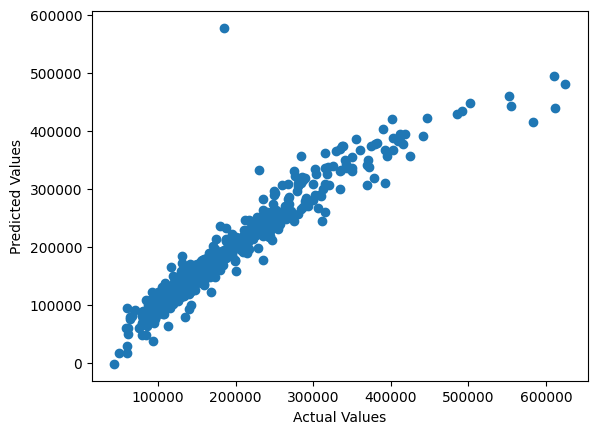

In [28]:
plt.scatter(y_test,y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

<Axes: xlabel='SalePrice'>

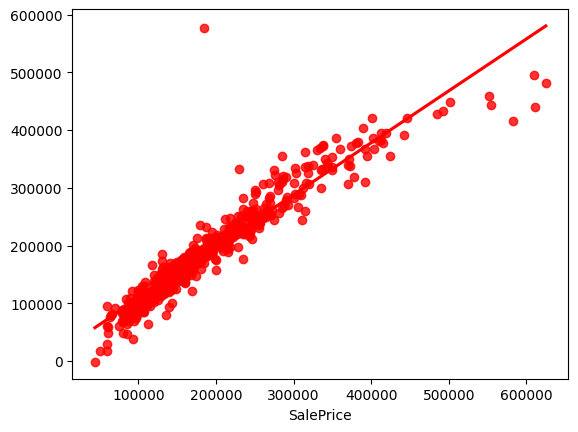

In [29]:
sns.regplot(x=y_test,y=y_pred,ci=None,color='red')

In [30]:
pred_df=pd.DataFrame({'Actual Values': y_test, 'Predicted Values': y_pred, 'Difference':y_test-y_pred})
pred_df

,Actual Values,Predicted Values,Difference
1357,161000,163342.077879,-2342.077879
2367,116000,111168.504558,4831.495442
2822,196500,194942.821729,1557.178271
2126,123600,137498.709891,-13898.709891
1544,126000,126723.174540,-723.174540
...,...,...,...
2268,187500,209920.141947,-22420.141947
456,552000,459561.591234,92438.408766
462,173000,192534.452948,-19534.452948
2168,118500,122441.016072,-3941.016072
